## Домашнее задание, вычисление аддитивного аттеншна

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [1]:
from tqdm import tqdm_notebook
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
!tail rus_eng_small.txt

она экономически независима от своих родителей .	she is economically independent of her parents .
она направила наши усилия в нужном направлении .	she steered our efforts in the right direction .
на этом заводе производят телевизоры .	they are manufacturing tv sets in this factory .
она всегда жалуется из за моей маленькой зарплаты .	she is always complaining about my small salary .
они стоят там и едят чипсы .	they are standing there and eating potato chips .
мне не удаётся скомпилировать эту программу .	i m having some problems compiling this software .
она улыбнулась в ответ на его нежный взгляд .	she smiled in response to his affectionate glance .
она проводит каждое воскресенье со своей бабушкой .	she spends time with her grandmother every sunday .
каждую субботу после обеда она играет в теннис .	she spends every saturday afternoon playing tennis .
после аварии она перестала бывать на людях .	she stopped appearing in public after her accident .


In [4]:
def readLangs():
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open('rus_eng_small.txt') as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [5]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...



Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['я так рад, что ты позвонила .', 'i m so glad you called .']


In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, nlayers, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

## Заполните метод вычисления аддитивного аттеншна в ячейке ниже.

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [8]:
class AttnDecoder(nn.Module):
    """
    Декодер с механизмом внимания dot-product attention
    T1 - шаги входной последовательности
    T2 - шаги выходной последовательности
    """
    def __init__(self, hidden_size, nlayers, output_size):
        """
        :param hidden_size - размер вектора состояния рекуррентного слоя
        :param nlayers - число рекуррентных слоев
        :param output_size - размер словаря выходных текстов
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        # !!! Define layers needed for additive attention here
        self.W_a = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v_a = nn.Linear(self.hidden_size, 1)
        # I also used dropout for training
        self.dropout_a = nn.Dropout(.1)
        
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, x, hidden, encoder_outputs):
        """
        :param x: [T2,B] - входной тензор с предыдущими словами размерностью timestep на batch
        :param hidden [1, B, C] - состояние рнн слоя
        :param encoder_outputs [T1,B,C] - выходы всех шагов энкодера
        :return output: [T2,B,C], hidden - С=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x) # [T2,B,C]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B,T1,C]
        outputs = []
        
        for i in range(x.size(0)):
            h_t = hidden[0].transpose(0, 1).transpose(1, -1) # [B, C, 1]

            context, attn_weights = self.attention(encoder_outputs, h_t)
        
            e = embedded[i].unsqueeze(0)
            output = torch.cat((e, context), dim=-1) # [[B,1,C];[B,1,C]] -> [B,1,C*2]
            output = self.attn_combine(output).transpose(0,1) # [B,1,C*2] * [C*2,C] = [B,1,C] -transpose-> [1,B,C]
            output = F.relu(output)
            output, hidden = self.rnn(output, hidden)

            logits = self.out(output)
            output = F.log_softmax(logits, dim=-1)
            outputs.append(output)
            
        output = torch.cat(outputs, dim=0)
        return output, hidden, attn_weights

    def attention(self, encoder_outputs, h):
        out = h.repeat(1, 1, encoder_outputs.size()[1]) # [B, C, 1] -> [B,C, T1]
        out = torch.cat([out, encoder_outputs.transpose(1, 2)], 1) # [B, 2C, T1]
        out = self.dropout_a(torch.tanh(self.W_a(out.transpose(1, 2)))) # [B, T1, C]
        out = self.v_a(out).transpose(1, 2) # [B, 1, T1]
        
        attn_weights = F.softmax(out, dim=-1) 
        
        context = torch.bmm(attn_weights, encoder_outputs)
        
        return context, attn_weights

In [9]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [10]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [11]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    print('Train')
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, iter / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [14]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
n_iters = 80_000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [ ]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words).to(device)

In [ ]:
teacher_forcing_ratio = .9
learning_rate = 0.001
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

### Не забудьте запустить тренировку в ячейке ниже, а затем и evaluation

2m 11s (- 27m 6s) (6000 7%) 2.3844
2m 57s (- 26m 33s) (8000 10%) 2.2827
3m 38s (- 25m 29s) (10000 12%) 2.1839
4m 29s (- 25m 29s) (12000 15%) 2.0291
5m 13s (- 24m 37s) (14000 17%) 1.9425
5m 52s (- 23m 30s) (16000 20%) 1.9234
6m 32s (- 22m 31s) (18000 22%) 1.8895
7m 10s (- 21m 31s) (20000 25%) 1.8160
7m 48s (- 20m 35s) (22000 27%) 1.6899
8m 27s (- 19m 43s) (24000 30%) 1.7066
9m 5s (- 18m 52s) (26000 32%) 1.7077
9m 47s (- 18m 11s) (28000 35%) 1.6401
10m 28s (- 17m 27s) (30000 37%) 1.5732
11m 7s (- 16m 40s) (32000 40%) 1.5436
11m 55s (- 16m 8s) (34000 42%) 1.5027
12m 38s (- 15m 27s) (36000 45%) 1.4694
13m 21s (- 14m 45s) (38000 47%) 1.4469
13m 59s (- 13m 59s) (40000 50%) 1.4226
14m 38s (- 13m 14s) (42000 52%) 1.4017
15m 18s (- 12m 31s) (44000 55%) 1.4296
15m 57s (- 11m 47s) (46000 57%) 1.3699
16m 35s (- 11m 3s) (48000 60%) 1.3195
17m 13s (- 10m 20s) (50000 62%) 1.2958
17m 52s (- 9m 37s) (52000 65%) 1.3331
18m 30s (- 8m 54s) (54000 67%) 1.2821
19m 8s (- 8m 12s) (56000 70%) 1.2429
19m 47s (-

<Figure size 432x288 with 0 Axes>

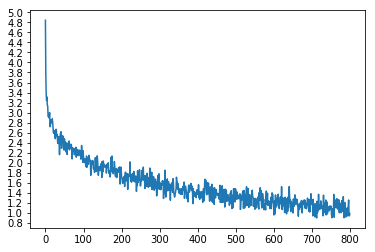

In [18]:
run_training(encoder, decoder, n_iters, print_every=2000)

In [19]:
decoder.eval()

AttnDecoder(
  (embedding): Embedding(3914, 256)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (W_a): Linear(in_features=512, out_features=256, bias=True)
  (v_a): Linear(in_features=256, out_features=1, bias=True)
  (dropout_a): Dropout(p=0.1)
  (rnn): LSTM(256, 256)
  (out): Linear(in_features=256, out_features=3914, bias=True)
)

In [20]:
evaluate_randomly(encoder, decoder)

> я очень спешу .
= i m in a big hurry .
< i m very in a hurry .

> я безобразна .
= i m ugly .
< i m an old .

> я безразлична .
= i m neutral .
< i m getting important .

> я уверен, что не знаю .
= i m sure i don t know .
< i m sure i don t know .

> мы очень за это благодарны .
= we re very grateful for that .
< we re very worried about it .

> мы идём на запад .
= we re going west .
< we re going to work .

> я уверен, что ты прав .
= i m sure you re right .
< i m sure you re right .

> он совершенен во всём .
= he s perfect at everything .
< he is a successful in love .

> я привык пить кофе без сахара .
= i m used to drinking coffee without sugar .
< i m used to this part of our .

> он хороший спортсмен .
= he is a good athlete .
< he is a good athlete .



torch.Size([6, 5])
input = я очень осторожна .
output = i m very disappointed .


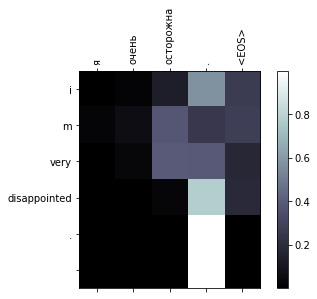

torch.Size([9, 9])
input = они всё ещё живут со своими родителями .
output = they are still living with their parents .


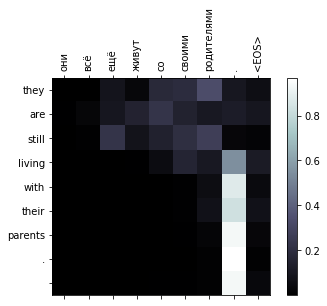

In [21]:
def showAttention(input_sentence, output_words, attentions):
    """
    Выведем attention более детально, подписав токены в позициях входной и выходной последовательностей
    """
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split() +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    print(attentions.size())
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я очень осторожна .")
evaluateAndShowAttention("они всё ещё живут со своими родителями .")